In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

from torch_linregr import *

# Integrating CPHS Data and Code

## Load Data

In [2]:
import pickle

with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)

#with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block2.pickle", 'rb') as handle:
#    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
#    refs_block2, _, _, _, emgs_block2, _, _, _, _, _, _ = pickle.load(handle)

In [3]:
keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
num_conds = 8
num_channels = 64
num_updates = 19
cphs_starting_update = 10
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

In [4]:
lambdaF = 0
lambdaD = 1e-10
lambdaE = 1e-6
lambdasFDE=[lambdaF, lambdaD, lambdaE]

# Base case: 1e-7/0, 1e-3, 1e-6
# Looks pretty similar to the base case @ 0,1e-6,1e-6
# @0,1e-4,1e-4: all are broken except FLDP (still static), but EMG Norm Off with PCA On is a great (very steep) elbow plot
# @0,1e-5,1e-5: the only one that blows up is the full dataset! FLDP still static.  Magnitudes start around 6-10
# @0,1e-7,1e-6: Nothing is broken! FLDP still static.  Magnitudes start around 1
# @0,1e-7,1e-5: Full breaks but everything else looks way better! FLDP still static.
# @0,1e-8,1e-5: Full breaks but everything else looks way better! FLDP still static.
# @0,1e-8,1e-6: Everything works! FLDP still static.  
# @0,1e-9,1e-6: Everything works! FLDP still static.  
# @0,1e-10,1e-6: Everything works! FLDP still static.  


In [5]:
print("Condition 1")
F1tens_full = torch.from_numpy(emgs_block1[keys[0]][0, :, :]).type(torch.float32)
PREF1tens_full = torch.from_numpy(refs_block1[keys[0]][0, :, :]).type(torch.float32)

print(f"EMG Input size: {F1tens_full.size()}")
print(f"2D Velocity Label size: {PREF1tens_full.size()}")

Condition 1
EMG Input size: torch.Size([20770, 64])
2D Velocity Label size: torch.Size([20770, 2])


## PyTorch Linear Regression With Full Dataset

In [6]:
num_updates = 19
starting_update = 0
normalize_emg = False
pca_channel_default = 64
PCA_comps = 64

total_epochs_FullData = 500

Norm of Final s: 33486.9140625
Norm of emg_streamed_batch: 33485.25
Norm of D: 0.8102189898490906
Norm of V: 3472.413330078125



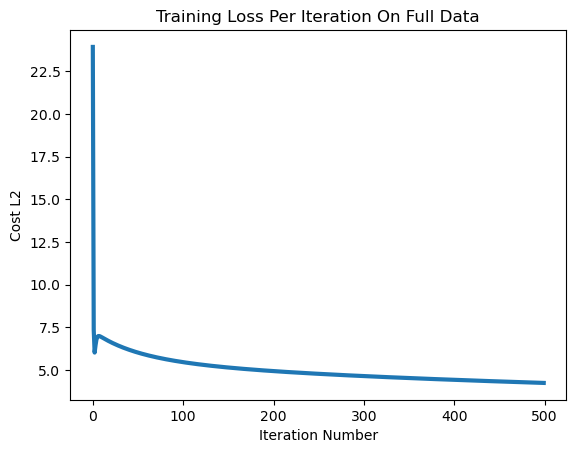

In [7]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

trained_model_FullData, loss_log_FullData, E_loss_log, D_loss_log = full_train_linregr_updates(untrained_model_FullData, F1tens_full, PREF1tens_full, learning_rate, return_cost_func_comps=True, num_iters_per_update=total_epochs_FullData, lambdasFDE=[lambdaF, lambdaD, lambdaE], stream_data_updates=False, use_full_input_data=True, starting_update=0)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss Per Iteration On Full Data")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

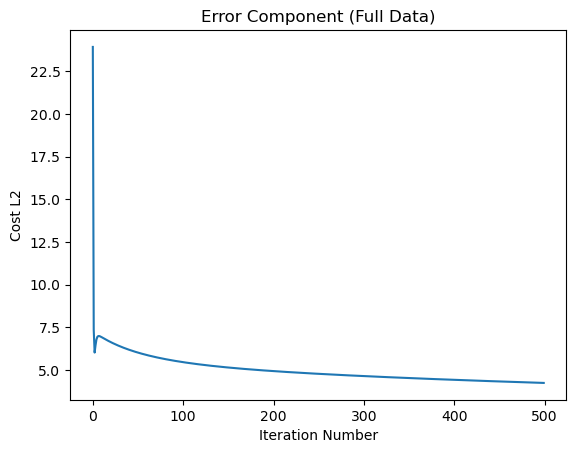

In [8]:
plt.plot([ele.detach().numpy() for ele in E_loss_log])
plt.title("Error Component (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

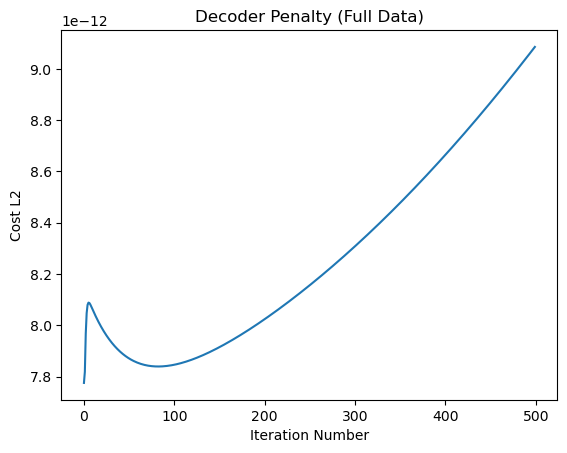

In [9]:
plt.plot([ele.detach().numpy() for ele in D_loss_log])
plt.title("Decoder Penalty (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Observe performance on first update only

Norm of Final s: 7408.75
Norm of emg_streamed_batch: 7405.02099609375
Norm of D: 0.8354540467262268
Norm of V: 115.93573760986328



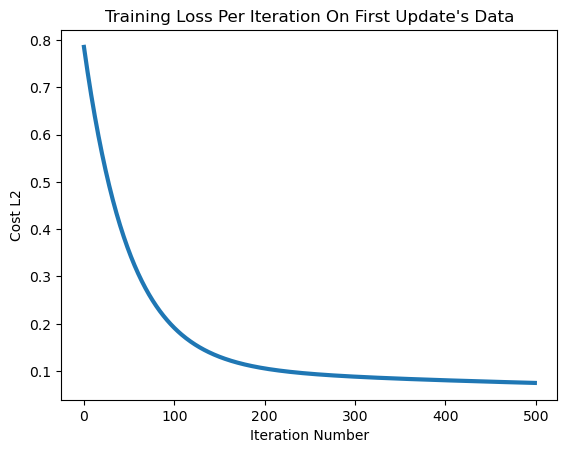

In [10]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FirstUpdate = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FirstUpdate.parameters(), lr=learning_rate)

trained_model_FirstUpdate, loss_log_FirstUpdate, _, _ = full_train_linregr_updates(untrained_model_FirstUpdate, F1tens_full[update_ix[0]:update_ix[1]], PREF1tens_full[update_ix[0]:update_ix[1]], learning_rate, return_cost_func_comps=True, lambdasFDE=[lambdaF, lambdaD, lambdaE], num_iters_per_update=total_epochs_FullData, stream_data_updates=False, use_full_input_data=True)

plt.plot(range(len(loss_log_FirstUpdate)), loss_log_FirstUpdate, linewidth=3)
plt.title("Training Loss Per Iteration On First Update's Data")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## PyTorch Linear Regression With Streamed Data

In [11]:
num_updates = 19
starting_update = 0
normalize_emg = False
pca_channel_default = 64
PCA_comps = 64

input_size = num_input_channels
output_size = 2  # 2D Velocity

Norm of Final s: 7412.6767578125
Norm of emg_streamed_batch: 7408.75
Norm of D: 0.7882384657859802
Norm of V: 76.58628845214844

Norm of Final s: 12297.6005859375
Norm of emg_streamed_batch: 12284.8759765625
Norm of D: 0.7872398495674133
Norm of V: 128.4747314453125

Norm of Final s: 7849.21923828125
Norm of emg_streamed_batch: 7846.20166015625
Norm of D: 0.7850744128227234
Norm of V: 51.38022232055664

Norm of Final s: 9085.3828125
Norm of emg_streamed_batch: 9081.1572265625
Norm of D: 0.7847176194190979
Norm of V: 43.42832946777344

Norm of Final s: 6062.30810546875
Norm of emg_streamed_batch: 6060.45361328125
Norm of D: 0.7843318581581116
Norm of V: 28.562904357910156

Norm of Final s: 7455.37158203125
Norm of emg_streamed_batch: 7454.99169921875
Norm of D: 0.7842062711715698
Norm of V: 33.841064453125

Norm of Final s: 6500.22705078125
Norm of emg_streamed_batch: 6496.6533203125
Norm of D: 0.783997118473053
Norm of V: 27.776029586791992

Norm of Final s: 8494.28125
Norm of emg_stre

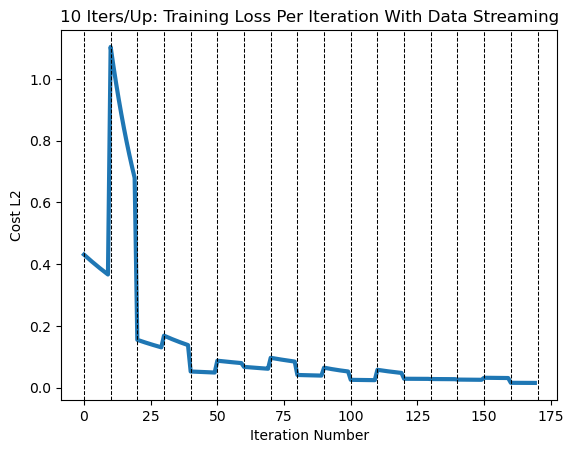

In [12]:
num_iters_per_update = 10

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_NoFL = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_NoFL.parameters(), lr=learning_rate)

trained_model_NoFL, loss_log_NoFL, _, _ = full_train_linregr_updates(untrained_model_NoFL, F1tens_full, PREF1tens_full, learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], return_cost_func_comps=True, num_iters_per_update=num_iters_per_update, starting_update=0)

plt.plot(range(len(loss_log_NoFL)), loss_log_NoFL, linewidth=3)
plt.title("10 Iters/Up: Training Loss Per Iteration With Data Streaming")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Norm of Final s: 7412.6767578125
Norm of emg_streamed_batch: 7408.75
Norm of D: 0.8086977601051331
Norm of V: 52.602970123291016

Norm of Final s: 12297.6005859375
Norm of emg_streamed_batch: 12284.8759765625
Norm of D: 0.802535355091095
Norm of V: 40.83208465576172

Norm of Final s: 7849.21923828125
Norm of emg_streamed_batch: 7846.20166015625
Norm of D: 0.797505795955658
Norm of V: 46.589778900146484

Norm of Final s: 9085.3828125
Norm of emg_streamed_batch: 9081.1572265625
Norm of D: 0.7943706512451172
Norm of V: 19.72865104675293

Norm of Final s: 6062.30810546875
Norm of emg_streamed_batch: 6060.45361328125
Norm of D: 0.791378915309906
Norm of V: 41.553138732910156

Norm of Final s: 7455.37158203125
Norm of emg_streamed_batch: 7454.99169921875
Norm of D: 0.7890192866325378
Norm of V: 23.306350708007812

Norm of Final s: 6500.22705078125
Norm of emg_streamed_batch: 6496.6533203125
Norm of D: 0.7851197123527527
Norm of V: 31.150386810302734

Norm of Final s: 8494.28125
Norm of emg_s

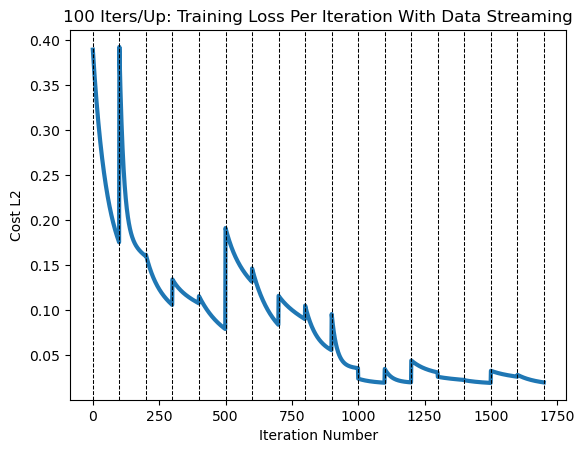

In [13]:
num_iters_per_update = 100

num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_NoFL = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_NoFL.parameters(), lr=learning_rate)

trained_model_NoFL, loss_log_NoFL, ETerm_loss_logg, DTerm_loss_log = full_train_linregr_updates(untrained_model_NoFL, F1tens_full, PREF1tens_full, learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], return_cost_func_comps=True, num_iters_per_update=num_iters_per_update, starting_update=0)

plt.plot(range(len(loss_log_NoFL)), loss_log_NoFL, linewidth=3)
plt.title("100 Iters/Up: Training Loss Per Iteration With Data Streaming")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

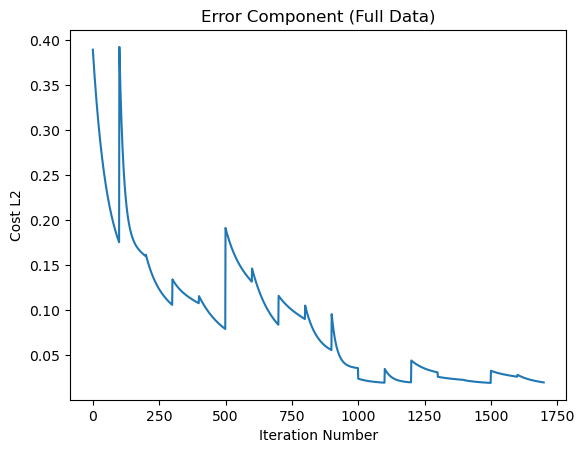

In [14]:
plt.plot([ele.detach().numpy() for ele in ETerm_loss_logg])
plt.title("Error Component (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

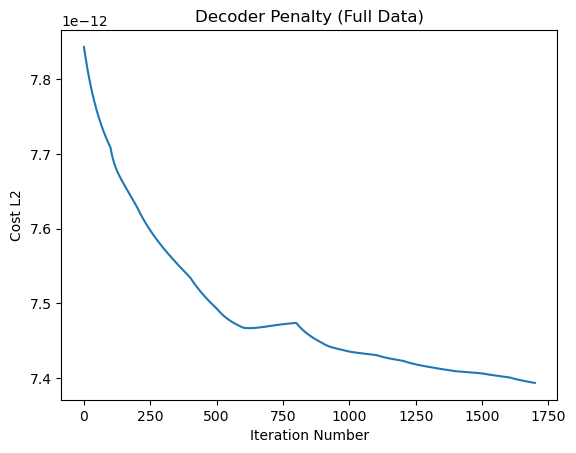

In [15]:
plt.plot([ele.detach().numpy() for ele in DTerm_loss_log])
plt.title("Decoder Penalty (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## Redo but with FL Data Processing Turned On

In [16]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = True
pca_channel_default = 64
PCA_comps = 7

# BUILD MODEL
num_input_channels = PCA_comps 
input_size = num_input_channels
# ^ IRL I'm not sure we are guaranteed to get equalength trials
#  Thus may be better to do every time point individually? Not sure
output_size = 2  # 2D Velocity
learning_rate = 0.0001

Norm of Final s: 0.3489197790622711
Norm of emg_streamed_batch: 0.3486567735671997
Norm of D: 0.7634577751159668
Norm of V: 14.960628509521484

Norm of Final s: 0.5611228942871094
Norm of emg_streamed_batch: 0.560920000076294
Norm of D: 0.7634577751159668
Norm of V: 15.687609672546387

Norm of Final s: 0.5182948708534241
Norm of emg_streamed_batch: 0.5180097222328186
Norm of D: 0.7634577751159668
Norm of V: 16.219696044921875

Norm of Final s: 0.516106128692627
Norm of emg_streamed_batch: 0.5157820582389832
Norm of D: 0.7634577751159668
Norm of V: 15.193668365478516

Norm of Final s: 0.45670729875564575
Norm of emg_streamed_batch: 0.45666858553886414
Norm of D: 0.7634577751159668
Norm of V: 15.86254596710205

Norm of Final s: 0.5579746961593628
Norm of emg_streamed_batch: 0.5578616857528687
Norm of D: 0.7634577751159668
Norm of V: 15.6319580078125

Norm of Final s: 0.4937290549278259
Norm of emg_streamed_batch: 0.49277177453041077
Norm of D: 0.7634577751159668
Norm of V: 15.92181682586

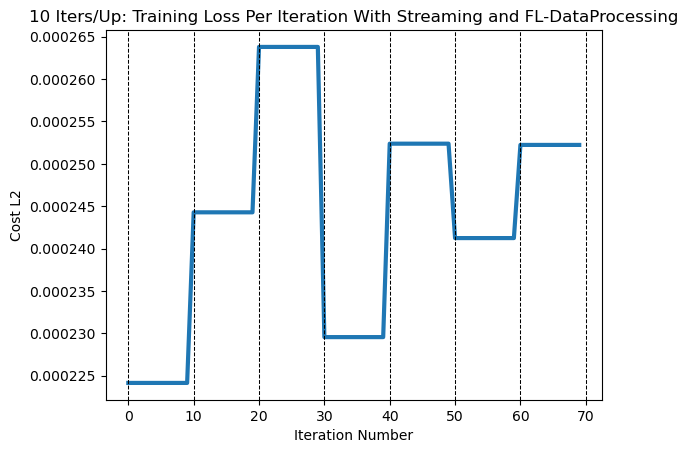

In [17]:
num_iters_per_update=10

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP.parameters(), lr=learning_rate)

trained_model_FLDP, loss_log_FLDP, _, _ = full_train_linregr_updates(untrained_model_FLDP, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, starting_update=10, lambdasFDE=[lambdaF, lambdaD, lambdaE], normalize_emg=True, return_cost_func_comps=True, PCA_comps=7, loss_log=[])

plt.plot(range(len(loss_log_FLDP)), loss_log_FLDP, linewidth=3)
plt.title("10 Iters/Up: Training Loss Per Iteration With Streaming and FL-DataProcessing")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Norm of Final s: 0.3489198088645935
Norm of emg_streamed_batch: 0.3486568331718445
Norm of D: 0.791212797164917
Norm of V: 14.960142135620117

Norm of Final s: 0.5611228942871094
Norm of emg_streamed_batch: 0.5609199404716492
Norm of D: 0.791212797164917
Norm of V: 15.687987327575684

Norm of Final s: 0.5182950496673584
Norm of emg_streamed_batch: 0.5180099010467529
Norm of D: 0.791212797164917
Norm of V: 16.219417572021484

Norm of Final s: 0.5161061882972717
Norm of emg_streamed_batch: 0.5157821178436279
Norm of D: 0.791212797164917
Norm of V: 15.19402027130127

Norm of Final s: 0.45670732855796814
Norm of emg_streamed_batch: 0.45666858553886414
Norm of D: 0.791212797164917
Norm of V: 15.862120628356934

Norm of Final s: 0.5579746961593628
Norm of emg_streamed_batch: 0.5578617453575134
Norm of D: 0.791212797164917
Norm of V: 15.631125450134277

Norm of Final s: 0.49372902512550354
Norm of emg_streamed_batch: 0.4927717447280884
Norm of D: 0.791212797164917
Norm of V: 15.9213285446167


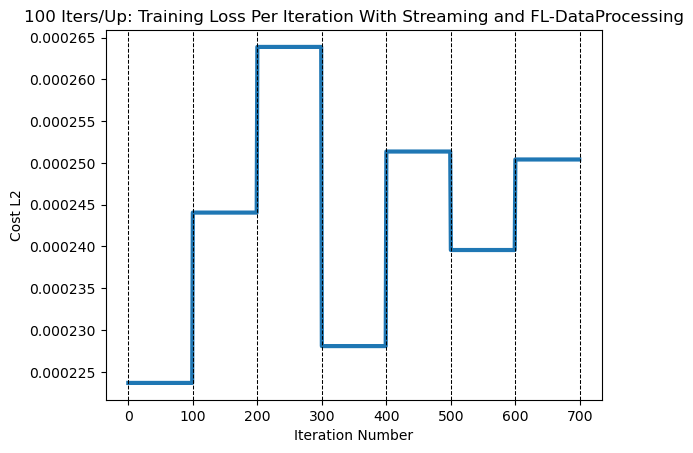

In [18]:
num_iters_per_update=100

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100, ETerm_log, DTerm_log = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, lambdasFDE=[lambdaF, lambdaD, lambdaE], starting_update=10, normalize_emg=True, return_cost_func_comps=True, PCA_comps=7, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("100 Iters/Up: Training Loss Per Iteration With Streaming and FL-DataProcessing")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

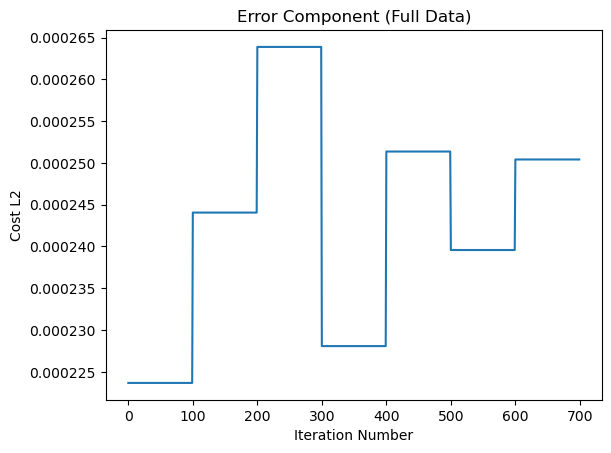

In [19]:
plt.plot([ele.detach().numpy() for ele in ETerm_log])
plt.title("Error Component (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

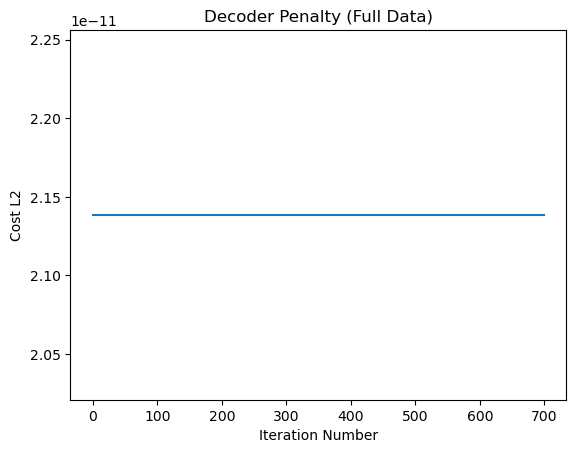

In [20]:
plt.plot([ele.detach().numpy() for ele in DTerm_log])
plt.title("Decoder Penalty (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Investigating why the above code is trash with static cost functions

Norm EMG but no PCA

Norm of Final s: 1.000000238418579
Norm of emg_streamed_batch: 0.9992555975914001
Norm of D: 0.8713774681091309
Norm of V: 14.960224151611328

Norm of Final s: 1.000002384185791
Norm of emg_streamed_batch: 0.999947726726532
Norm of D: 0.8713774681091309
Norm of V: 15.687284469604492

Norm of Final s: 0.9999994039535522
Norm of emg_streamed_batch: 0.9992942810058594
Norm of D: 0.8713774681091309
Norm of V: 16.219026565551758

Norm of Final s: 0.9999996423721313
Norm of emg_streamed_batch: 0.999208390712738
Norm of D: 0.8713774681091309
Norm of V: 15.195906639099121

Norm of Final s: 0.9999997019767761
Norm of emg_streamed_batch: 0.9997628331184387
Norm of D: 0.8713774681091309
Norm of V: 15.863253593444824

Norm of Final s: 1.000000238418579
Norm of emg_streamed_batch: 0.9994613528251648
Norm of D: 0.8713774681091309
Norm of V: 15.631661415100098

Norm of Final s: 1.000000238418579
Norm of emg_streamed_batch: 0.9987019896507263
Norm of D: 0.8713774681091309
Norm of V: 15.91912841796875


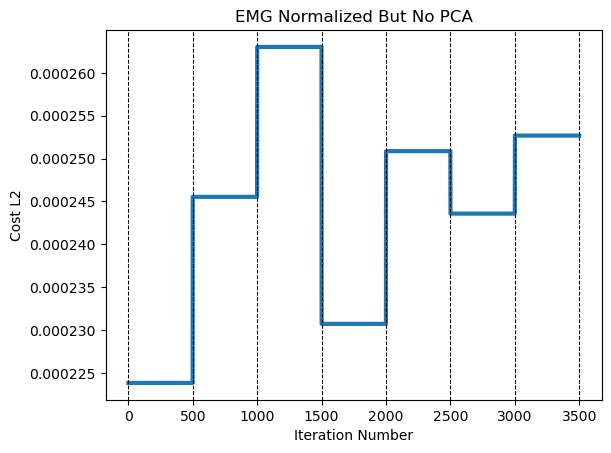

In [21]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = True
pca_channel_default = 64
PCA_comps = 64

#######################################################################

num_iters_per_update=500

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100, E, D  = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, lambdasFDE=[lambdaF, lambdaD, lambdaE], starting_update=10, normalize_emg=normalize_emg, PCA_comps=PCA_comps, return_cost_func_comps=True, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("EMG Normalized But No PCA")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

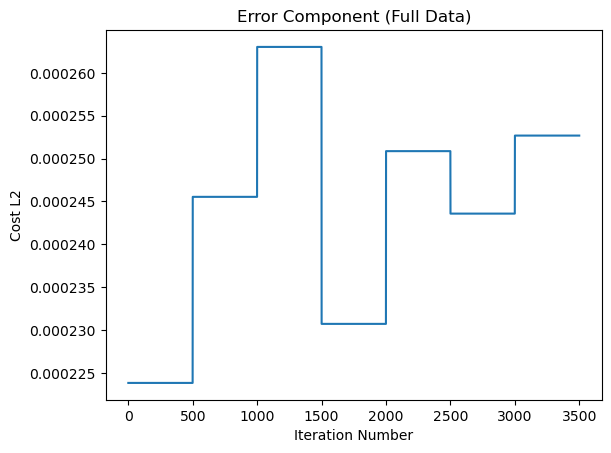

In [22]:
plt.plot([ele.detach().numpy() for ele in E])
plt.title("Error Component (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

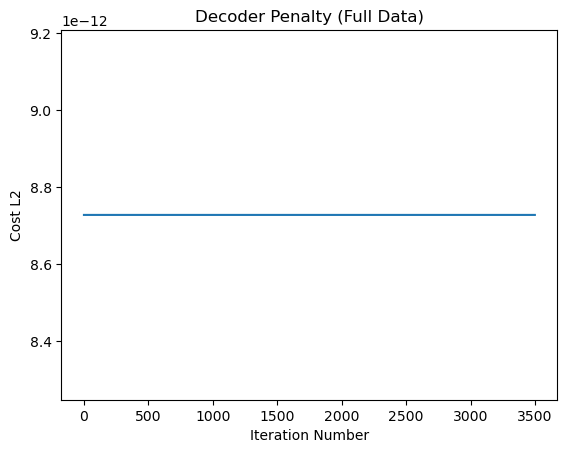

In [23]:
plt.plot([ele.detach().numpy() for ele in D])
plt.title("Decoder Penalty (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Don't Normalize EMG but do use PCA

Norm of Final s: 2368.89306640625
Norm of emg_streamed_batch: 2367.107421875
Norm of D: 0.8913898468017578
Norm of V: 40.371673583984375

Norm of Final s: 5350.3642578125
Norm of emg_streamed_batch: 5348.4296875
Norm of D: 0.8290061354637146
Norm of V: 75.75977325439453

Norm of Final s: 3402.399169921875
Norm of emg_streamed_batch: 3400.52734375
Norm of D: 0.7678796648979187
Norm of V: 33.00191116333008

Norm of Final s: 2850.306640625
Norm of emg_streamed_batch: 2848.5166015625
Norm of D: 0.7249746918678284
Norm of V: 23.497838973999023

Norm of Final s: 3093.62060546875
Norm of emg_streamed_batch: 3093.358154296875
Norm of D: 0.6983538269996643
Norm of V: 16.639841079711914

Norm of Final s: 4448.76708984375
Norm of emg_streamed_batch: 4447.8662109375
Norm of D: 0.6734821200370789
Norm of V: 25.448827743530273

Norm of Final s: 3168.70654296875
Norm of emg_streamed_batch: 3162.562744140625
Norm of D: 0.6520678997039795
Norm of V: 17.194683074951172



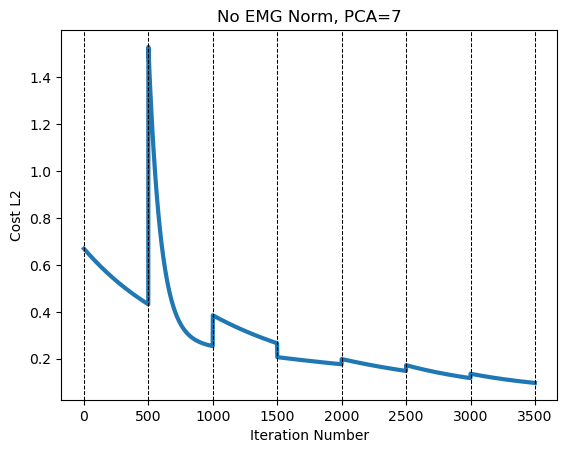

In [24]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = False
pca_channel_default = 64
PCA_comps = 7

#######################################################################

num_iters_per_update=500

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100, E, D = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, return_cost_func_comps=True, num_iters_per_update=num_iters_per_update, starting_update=10, lambdasFDE=[lambdaF, lambdaD, lambdaE], normalize_emg=normalize_emg, PCA_comps=PCA_comps, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("No EMG Norm, PCA=7")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

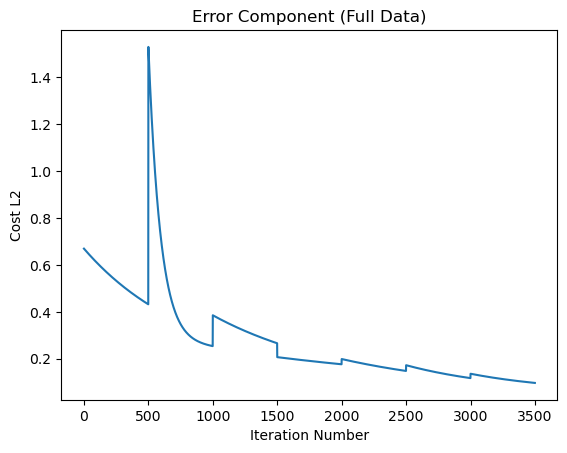

In [25]:
plt.plot([ele.detach().numpy() for ele in E])
plt.title("Error Component (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

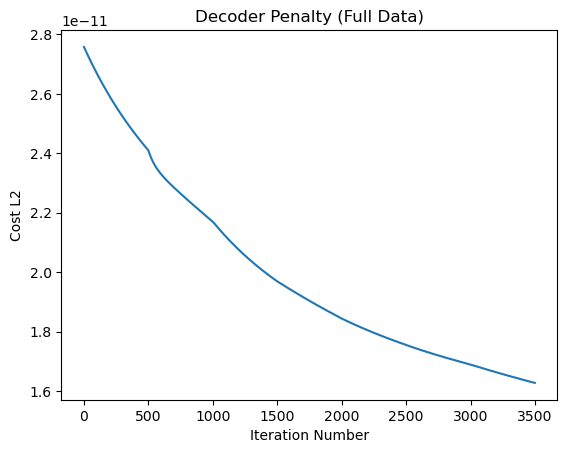

In [26]:
plt.plot([ele.detach().numpy() for ele in D])
plt.title("Decoder Penalty (Full Data)")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()